In [1]:
import os
import cv2
from pydub import AudioSegment
import librosa
import numpy as np
import scipy.signal
import shutil
from PIL import Image

In [2]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

In [3]:
def get_audio(video_path, audio_output_path = 'audio.wav'):

    audio = AudioSegment.from_file(video_path)
    
    audio.export(audio_output_path, format='wav')
    
    return audio_output_path

In [4]:
def spectrogram_analysis(audio_path, freq_range):
   
    signal, rate = librosa.load(audio_path, sr = None)
    
    freqs, t, spect = scipy.signal.spectrogram(signal, fs = rate)
     
    masking = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    
    masked_spect = spect[masking, :]
    
    if masked_spect.size == 0:
        raise ValueError("No frequencies found in that range.")
        
    peak = np.argmax(np.mean(masked_spect, axis=0))
    time_peak = t[peak]
    
    return time_peak

In [5]:
def get_frame(video_path, secs, frame_path):

    vid = cv2.VideoCapture(video_path)
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(secs * vid.get(cv2.CAP_PROP_FPS)))
    
    op, frame = vid.read()
    
    if op: 
        
        cv2.imwrite(frame_path, frame)
        
    vid.release()

In [6]:
def process_videos(input_folder, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for video_file in os.listdir(input_folder):
        
        if video_file.endswith('.avi'):
            video_path = os.path.join(input_folder, video_file)
            audio_path = get_audio(video_path)
            
            peak_time = spectrogram_analysis(audio_path, (1000, 2000))
            frame_path = os.path.join(output_folder, video_file.replace('.avi', '.jpg'))
            get_frame(video_path, peak_time, frame_path)

            os.remove(audio_path) 

In [7]:
folders = ['cover', 'sweep', 'pull', 'straight', 'flick', 'square_cut']

for folder in folders:
    
    input_folder = os.path.join('/Users/vamsikrishnajayaram/Downloads/', folder)
    output_folder = os.path.join('/Users/vamsikrishnajayaram/Downloads/shot_images', folder)

    process_videos(input_folder, output_folder)

In [8]:
def flip_image(img_path):
    
    img = cv2.imread(img_path)
    img_flip = cv2.flip(img, 1)
    return img_flip

def process_images_flip(input_folder, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for folder_name in os.listdir(input_folder):
        subfolder_path = os.path.join(input_folder, folder_name)
        if os.path.isdir(subfolder_path):
            output_subfolder = os.path.join(output_folder, folder_name)

            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)

            for filename in os.listdir(subfolder_path):
                
                if filename.lower().endswith('.jpg'): 
                    
                    img_path = os.path.join(subfolder_path, filename)
                    flipped_img = flip_image(img_path)

                    output_path = os.path.join(output_subfolder, filename)
                    cv2.imwrite(output_path, flipped_img)

input_folder = '/Users/vamsikrishnajayaram/Downloads/shot_images'
output_folder = '/Users/vamsikrishnajayaram/Downloads/flipped_shot_images'

process_images_flip(input_folder, output_folder)

In [9]:
base_path = "/Users/vamsikrishnajayaram/Downloads"
original_images_path = os.path.join(base_path, "shot_images")
flipped_images_path = os.path.join(base_path, "flipped_shot_images")

shot_types = ["cover", "sweep", "pull", "straight", "flick", "square_cut"]

target_size = (224, 224)

dataset = []
labels = []

for index, shot_type in enumerate(shot_types):
    
    original_images_dir = os.path.join(original_images_path, shot_type)
    flipped_images_dir = os.path.join(flipped_images_path, shot_type)

    for image_filename in os.listdir(original_images_dir):
        
        image_path = os.path.join(original_images_dir, image_filename)
        
        if os.path.isfile(image_path):
            image = Image.open(image_path)
            image = image.resize(target_size)  
            dataset.append(np.array(image))
            labels.append(index) 

    for image_filename in os.listdir(flipped_images_dir):
        
        image_path = os.path.join(flipped_images_dir, image_filename)
        
        if os.path.isfile(image_path):
            image = Image.open(image_path)
            image = image.resize(target_size)  
            dataset.append(np.array(image))
            labels.append(index) 

dataset = np.array(dataset)
labels = np.array(labels)

print(f"Total {len(dataset)} images.")

Total 2270 images.


In [10]:
types = {0: "cover", 1: "sweep", 2: "pull", 3: "straight", 4: "flick", 5: "square_cut"}

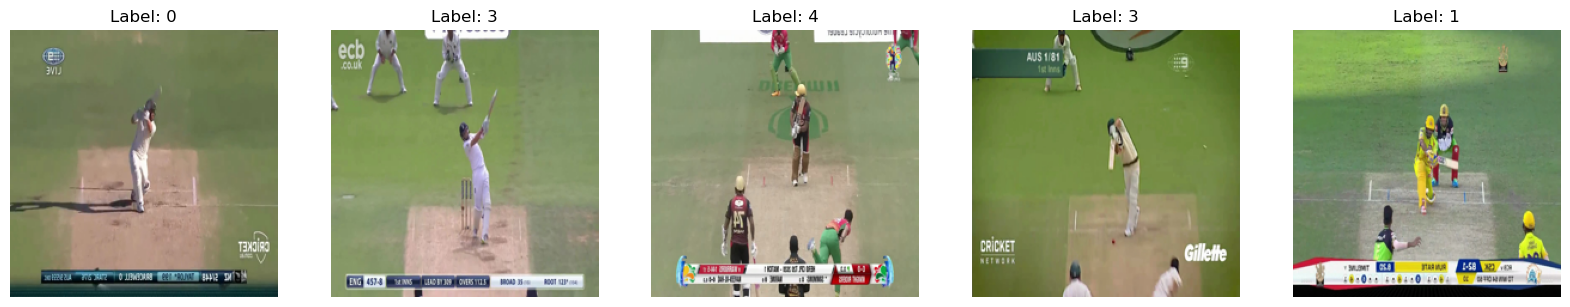

In [11]:
np.random.seed(18)
random_indices = np.random.choice(len(dataset), 5)

fig, axes = plt.subplots(1, 5, figsize = (20, 4))

for ax, idx in zip(axes, random_indices):
    
    ax.imshow(dataset[idx])
    ax.axis('off')
    ax.set_title(f"Label: {labels[idx]}")

plt.show()